In [ ]:
#ddpg

In [ ]:
import math
from typing import Optional

import numpy as np

import gym
from gym import spaces
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled


class Continuous_MountainCarEnv_Custom(gym.Env):
    """
    ### Description
    The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically
    at the bottom of a sinusoidal valley, with the only possible actions being the accelerations
    that can be applied to the car in either direction. The goal of the MDP is to strategically
    accelerate the car to reach the goal state on top of the right hill. There are two versions
    of the mountain car domain in gym: one with discrete actions and one with continuous.
    This version is the one with continuous actions.
    This MDP first appeared in [Andrew Moore's PhD Thesis (1990)](https://www.cl.cam.ac.uk/techreports/UCAM-CL-TR-209.pdf)
    ```
    @TECHREPORT{Moore90efficientmemory-based,
        author = {Andrew William Moore},
        title = {Efficient Memory-based Learning for Robot Control},
        institution = {University of Cambridge},
        year = {1990}
    }
    ```
    ### Observation Space
    The observation is a `ndarray` with shape `(2,)` where the elements correspond to the following:
    | Num | Observation                          | Min  | Max | Unit         |
    |-----|--------------------------------------|------|-----|--------------|
    | 0   | position of the car along the x-axis | -Inf | Inf | position (m) |
    | 1   | velocity of the car                  | -Inf | Inf | position (m) |
    ### Action Space
    The action is a `ndarray` with shape `(1,)`, representing the directional force applied on the car.
    The action is clipped in the range `[-1,1]` and multiplied by a power of 0.0015.
    ### Transition Dynamics:
    Given an action, the mountain car follows the following transition dynamics:
    *velocity<sub>t+1</sub> = velocity<sub>t+1</sub> + force * self.power - 0.0025 * cos(3 * position<sub>t</sub>)*
    *position<sub>t+1</sub> = position<sub>t</sub> + velocity<sub>t+1</sub>*
    where force is the action clipped to the range `[-1,1]` and power is a constant 0.0015.
    The collisions at either end are inelastic with the velocity set to 0 upon collision with the wall.
    The position is clipped to the range [-1.2, 0.6] and velocity is clipped to the range [-0.07, 0.07].
    ### Reward
    A negative reward of *-0.1 * action<sup>2</sup>* is received at each timestep to penalise for
    taking actions of large magnitude. If the mountain car reaches the goal then a positive reward of +100
    is added to the negative reward for that timestep.
    ### Starting State
    The position of the car is assigned a uniform random value in `[-0.6 , -0.4]`.
    The starting velocity of the car is always assigned to 0.
    ### Episode End
    The episode ends if either of the following happens:
    1. Termination: The position of the car is greater than or equal to 0.45 (the goal position on top of the right hill)
    2. Truncation: The length of the episode is 999.
    ### Arguments
    ```
    gym.make('MountainCarContinuous-v0')
    ```
    ### Version History
    * v0: Initial versions release (1.0.0)
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }

    def __init__(self, render_mode: Optional[str] = None, goal_velocity=0):
        self.min_action = -1.0
        self.max_action = 1.0
        self.min_position = -1.2
        self.max_position = 0.6
        self.max_speed = 0.07
        self.max_step = 1000 # change from 999 for convient
        self.current_step = 0

        #self.tau1 = .001
        self.tau = 1.0 # seconds between state updates
        self.tau1 = .05 # integration time sample
        #self.tau1 = 1.0 # integration time sample
        #self.kinematics_integrator = "euler"

        #self.Resistor_R=1.0
        #self.inductor_L=0.1
        #self.torque_const_Kt=1.0
        #self.bemf_const_Ke=1.0
        self.DCMotorModel = ElectricalDCMotorEnv()##################################################################################################################
        self.DCMotorModel.tau1 = self.tau1
        self.DCMotorModel.Resistor_R = 1.0
        self.DCMotorModel.inductor_L = 0.1
        self.DCMotorModel.torque_const_Kt = 1.0
        self.DCMotorModel.bemf_const_Ke = 1.0


        self.goal_position = (
            0.45  # was 0.5 in gym, 0.45 in Arnaud de Broissia's version
        )
        self.goal_velocity = goal_velocity
        self.power = 0.0015

        self.low_state = np.array(
            [self.min_position, -self.max_speed], dtype=np.float32
        )
        self.high_state = np.array(
            [self.max_position, self.max_speed], dtype=np.float32
        )

        self.render_mode = render_mode

        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.clock = None
        self.isopen = True

        self.action_space = spaces.Box(
            low=self.min_action, high=self.max_action, shape=(1,), dtype=np.float32
        )
        self.observation_space = spaces.Box(
            low=self.low_state, high=self.high_state, dtype=np.float32
        )

    def step(self, action: np.ndarray):

        position = self.state[0]
        velocity = self.state[1]
        force = min(max(action[0], self.min_action), self.max_action)#The action is clipped in the range [-1,1] and multiplied by a power of 0.0015

        current_ref = force/self.DCMotorModel.torque_const_Kt

        for t in np.arange(start=0.0, stop=self.tau, step=self.tau1):
          u_after_pid = self.DCMotorModel.step(current_ref = current_ref, theta_dot = velocity)##########################################################
          u_after_pid = min(max(u_after_pid, self.min_action), self.max_action)
          #u_after_pid=force
          # NOTE: if tau=1 and tau1=1 and u_after_pid=force (no feed thru PID),
          #      then we have the "ideal" mountain car ENV

          velocity += (u_after_pid * self.power - 0.0025 * math.cos(3 * position))*self.tau1
          if velocity > self.max_speed:
              velocity = self.max_speed
          if velocity < -self.max_speed:
              velocity = -self.max_speed
          position += (velocity)*self.tau1
          if position > self.max_position:
              position = self.max_position
          if position < self.min_position:
              position = self.min_position
          if position == self.min_position and velocity < 0:
              velocity = 0

        # Convert a possible numpy bool to a Python bool.

        terminated = bool(
            position >= self.goal_position #and velocity >= self.goal_velocity
        )
        '''
        terminated = bool(
            position >= self.goal_position and np.abs(
                velocity-self.goal_velocity) < 10**(-3)
        )
        '''
        reward = 0
        if terminated:
            #print("1_terminated :",terminated)
            #terminated = False
            #print("3_terminated :",terminated)
            reward = 100.0
        reward -= math.pow(u_after_pid, 2) * 0.1
        #reward -= math.pow(action[0], 2) * 0.1
        #print("position :",position)
        self.state = np.array([position, velocity], dtype=np.float32)

        if self.render_mode == "human":
            self.render()

        self.current_step += 1
        #print("self.current_step :", self.current_step)
        terminated_end_of_episode = bool(self.current_step % self.max_step == 0)##########################################################################
        #print("terminated_end_of_episode :", terminated_end_of_episode)
        if (terminated == True) or (terminated_end_of_episode == True):
          terminated = True
          self.current_step = 0
          #print("2_terminated :",terminated)



        return self.state, reward, terminated, False , force , u_after_pid

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        low, high = utils.maybe_parse_reset_bounds(options, -0.6, -0.4)
        self.state = np.array([self.np_random.uniform(low=low, high=high), 0])

        self.DCMotorModel.current = 0.0
        self.DCMotorModel.current_error = 0.0
        self.DCMotorModel.current_error_acc = 0.0
        self.DCMotorModel.current_error_prev = 0.0

        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), {}

    def _height(self, xs):
        return np.sin(3 * xs) * 0.45 + 0.55

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[classic_control]`"
            )

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_width, self.screen_height)
                )
            else:  # mode == "rgb_array":
                self.screen = pygame.Surface((self.screen_width, self.screen_height))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        world_width = self.max_position - self.min_position
        scale = self.screen_width / world_width
        carwidth = 40
        carheight = 20

        self.surf = pygame.Surface((self.screen_width, self.screen_height))
        self.surf.fill((255, 255, 255))

        pos = self.state[0]

        xs = np.linspace(self.min_position, self.max_position, 100)
        ys = self._height(xs)
        xys = list(zip((xs - self.min_position) * scale, ys * scale))

        pygame.draw.aalines(self.surf, points=xys, closed=False, color=(0, 0, 0))

        clearance = 10

        l, r, t, b = -carwidth / 2, carwidth / 2, carheight, 0
        coords = []
        for c in [(l, b), (l, t), (r, t), (r, b)]:
            c = pygame.math.Vector2(c).rotate_rad(math.cos(3 * pos))
            coords.append(
                (
                    c[0] + (pos - self.min_position) * scale,
                    c[1] + clearance + self._height(pos) * scale,
                )
            )

        gfxdraw.aapolygon(self.surf, coords, (0, 0, 0))
        gfxdraw.filled_polygon(self.surf, coords, (0, 0, 0))

        for c in [(carwidth / 4, 0), (-carwidth / 4, 0)]:
            c = pygame.math.Vector2(c).rotate_rad(math.cos(3 * pos))
            wheel = (
                int(c[0] + (pos - self.min_position) * scale),
                int(c[1] + clearance + self._height(pos) * scale),
            )

            gfxdraw.aacircle(
                self.surf, wheel[0], wheel[1], int(carheight / 2.5), (128, 128, 128)
            )
            gfxdraw.filled_circle(
                self.surf, wheel[0], wheel[1], int(carheight / 2.5), (128, 128, 128)
            )

        flagx = int((self.goal_position - self.min_position) * scale)
        flagy1 = int(self._height(self.goal_position) * scale)
        flagy2 = flagy1 + 50
        gfxdraw.vline(self.surf, flagx, flagy1, flagy2, (0, 0, 0))

        gfxdraw.aapolygon(
            self.surf,
            [(flagx, flagy2), (flagx, flagy2 - 10), (flagx + 25, flagy2 - 5)],
            (204, 204, 0),
        )
        gfxdraw.filled_polygon(
            self.surf,
            [(flagx, flagy2), (flagx, flagy2 - 10), (flagx + 25, flagy2 - 5)],
            (204, 204, 0),
        )

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False

In [ ]:
class ElectricalDCMotorEnv():

      def __init__(self):
        self.Resistor_R = 1.0
        self.inductor_L = 0.1
        self.torque_const_Kt = 1.0
        self.bemf_const_Ke = 1.0
        #self.tau1 = 1.0
        self.tau1 = 0.001 ##################################################################################################

        #self.Kp = 1.0
        #self.Ki = 0.1
        #self.Kd = 10**(-3.5)
        #self.aL=10**(-3)+(7./3 - 4./3 -1)#Low pass parameter
        #self.aH = 10**2 #High pass parameter
        '''
        self.Kp = 5.0
        self.Ki = 1.0**(0)
        self.Kd = 10**(-5)
        self.aL=10.0**(-3) #Low pass parameter
        self.aH = 10.0**2 #High pass parameter
        '''
        '''
        self.Kp = 1.0
        self.Ki = 1.0**(0)
        self.Kd = 10**(0)
        self.aL=10.0**(0) #Low pass parameter
        self.aH = 10.0**0 #High pass parameter
        '''
        self.Kp = 2.0 #1.0
        self.Ki = 10.0 # 10, 20 or 30
        self.Kd = 10**(-3) #10**(-6)
        self.aL=10.0**(-3) #Low pass parameter
        self.aH = 10.0**2 #High pass parameter

        #
        self.current = 0.0
        self.current_error = 0.0
        self.current_error_acc = 0.0
        self.current_error_prev = 0.0
        self.voltage_input = 0.0
        #self.xdot = 0.0###########################
        self.thetadot = 0.0
        #self.PID_Discretization = "Simple" #"Backward", " "Bilinear" , "Forward" "Simple"
        #self.PID_Discretization = "Backward" #"Backward""Simple", " "Bilinear" , "Forward" "Simple"
        self.PID_Discretization = "Simple" #"Backward""Simple", " "Bilinear" , "Forward" "Simple"

      def step(self, current_ref, theta_dot):
        aL = self.aL
        aH = self.aH
        self.current_error = current_ref-self.current
        delta_error = self.current_error-self.current_error_prev

        if self.PID_Discretization == "Simple":
          self.current_error_acc += self.current_error*self.tau1
          HP_delta_error = delta_error

        elif self.PID_Discretization == "Backward":
          self.current_error_acc = (self.current_error_acc+(self.current_error)*self.tau1)/(1+aL*self.tau1)
          HP_delta_error = (self.current_error + aH*delta_error)/(1+aL*self.tau1)#High Pass

        elif self.PID_Discretization == "Bilinear":
          error_avg = (self.current_error+self.current_error_prev)/2
          self.current_error_acc =  ((1-aL*self.tau1/2)*self.current_error_acc + error_avg*self.tau1)/(1+aL*self.tau1/2)#Low Pass
          HP_delta_error =  ((1-aL*self.tau1/2)*self.current_error + aH*delta_error)/(1+aL*self.tau1/2)#High Pass

        else:
          self.current_error_acc = (1-aL*self.tau1)*self.current_error_acc+(self.current_error_prev)*self.tau1 #Low Pass
          HP_delta_error = (1-aH*self.tau1)*self.current_error + aH*delta_error #High Pass

        P = self.Kp*self.current_error
        #I = self.Ki*self.current_error_acc*self.tau1
        I = self.Ki*self.current_error_acc
        #D = self.Kd*HP_delta_error/self.tau1
        D = self.Kd*HP_delta_error/self.tau1
        voltage_BEMF = theta_dot*self.bemf_const_Ke
        voltage_input = P+I+D+voltage_BEMF
        voltage_input = np.clip(voltage_input, -10, 10)

        self.current_error_prev = 0+self.current_error
        self.current += self.tau1*(voltage_input-voltage_BEMF-self.current*self.Resistor_R)/self.inductor_L
        #lower_bound = -2.0, upper_bound = 2.0
        #self.current = np.clip(self.current, -10.0, 10.0)##########################################################################change_2
        #self.current = np.clip(self.current, -2.0, 2.0)
        #print("the current is",self.current)

        self.voltage_input = voltage_input
        #print("the voltage is",self.voltage_input)
        self.thetadot = theta_dot
        F = self.torque_const_Kt*self.current

        return F # return applied Tourqe

In [ ]:
from gym import make
import random
import numpy as np
from collections import namedtuple, deque
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
Transaction = namedtuple('Transaction',
                         ('state', 'action', 'next_state', 'reward'))


class Buffer(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.appendleft(Transaction(*args))

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        batch = Transaction(*zip(*batch))
        self.state = torch.tensor(batch.state, dtype = torch.float)
        self.action = torch.tensor(batch.action, dtype = torch.float)
        self.next_state = torch.tensor(batch.next_state, dtype = torch.float)
        self.reward = torch.tensor(batch.reward, dtype = torch.float)

    def __len__(self):
        return len(self.memory)

In [ ]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        #print("x_1 : ", x)
        x = F.relu(self.fc1(x))
        #print("x_2 : ", x)
        x = F.relu(self.fc2(x))
        #print("x_3 : ", x)
        x = self.fc3(x)
        #print("x_4 : ", x)
        #print("torch.tanh(x) : ", torch.tanh(x))
        return torch.tanh(x)


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64 + action_dim, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x, a):
        #print("x_5 : ", x)
        x = F.relu(self.fc1(x))
        #print("x_6 : ", x)
        #print("self.fc2(torch.cat([x, a], dim=1) : ", self.fc2(torch.cat([x, a], dim=1)))
        x = F.relu(self.fc2(torch.cat([x, a], dim=1)))
        #print("x_7 : ", x)
        x = self.fc3(x)
        #print("x_8 : ", x)
        return x

In [ ]:
class Noise:
    def __init__(self, mu=0.0, theta=0.1, sigma=0.1):
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.action_dim = 1
        self.low = -1.0
        self.high = 1.0
        self.state = np.ones(self.action_dim) * self.mu

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

In [ ]:
class AQL:
    def __init__(self, states, actions, eps, episodes, batch_size, mem_sz, alpha_actor,
                 alpha_critic, gamma, tau):
        self.gamma = gamma
        self.alpha_actor = alpha_actor
        self.alpha_critic = alpha_critic
        self.eps = eps
        self.episodes = episodes
        self.batch_size = batch_size
        self.memory = Buffer(mem_sz)
        self.tau = tau
        self.noise = Noise()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.actor = Actor(states, actions).to(self.device).apply(self.weights)
        self.critic = Critic(states, actions).to(self.device).apply(self.weights)

        self.actor_target = Actor(states, actions).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())

        self.critic_target = Critic(states, actions).to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        self.actor_optim = optim.Adam(self.actor.parameters(), lr=self.alpha_actor)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=self.alpha_critic)
        self.critic_criterion = nn.MSELoss()

    @staticmethod
    def weights(layer):
        if isinstance(layer, nn.Linear):
            nn.init.xavier_normal_(layer.weight)

    def update(self):
        if len(self.memory) <= self.batch_size:
            return
        self.memory.sample(self.batch_size)
        Qvals = self.critic.forward(self.memory.state, self.memory.action.unsqueeze(1))
        next_actions = self.actor_target.forward(self.memory.next_state)
        next_Q = self.critic_target.forward(self.memory.next_state, next_actions.detach())
        Qprime = self.memory.reward.unsqueeze(1) + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)
        policy_loss = -self.critic.forward(self.memory.state, self.actor.forward(self.memory.state)).mean()

        self.actor_optim.zero_grad()
        policy_loss.backward()
        self.critic_optim.zero_grad()
        critic_loss.backward()

        for param_actor, param_critic in zip(self.actor.parameters(), self.critic.parameters()):
            param_actor.grad.data.clamp_(-1, 1)
            param_critic.grad.data.clamp_(-1, 1)
        self.actor_optim.step()
        self.critic_optim.step()

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

    def act(self, state):
        return np.clip(self.actor(state).detach() + self.eps * self.noise.noise(), -1.0, 1.0)

In [ ]:
class Test:
    def __init__(self, path, rewards, test_episodes):
        self.rewards = rewards
        self.test_episodes = test_episodes
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = torch.load(path).to(self.device)
        self.run()

    def act(self, state):
        #state = np.asarray(state[0])
        state = torch.tensor(state, dtype = torch.float).unsqueeze(0)
        with torch.no_grad():
            return self.model(state)

    def run(self):
        #env = make('MountainCarContinuous-v0')####################################################################################################################################
        env = Continuous_MountainCarEnv_Custom()
        env.DCMotorModel.PID_Discretization ="Simple" # "Forward" or "Backward" or" "Bilinear" or "Simple"
        rewards = []
        for i in range(self.test_episodes):
            state = env.reset()
            state = np.asarray(state[0])
            total_reward = 0
            done = False
            while not done:
                #state = np.asarray(state[0])
                action = self.act(state)
                next_state, reward, done, _ , force , u_after_pid = env.step(action) #  self.state, reward, terminated, False , force , u_after_pid
                total_reward += reward
                state = next_state
            rewards.append(total_reward)
        self.test_rewards = rewards
        self.m = np.mean(rewards)
        #self.m = np.mean(self.m )#######################################################################

    def picture(self):
        plt.figure(figsize=(16, 16))
        ax1 = plt.subplot(421)
        ax2 = plt.subplot(422)
        ax1.plot(np.arange(0, len(self.rewards)), self.rewards, label=f'rewards')
        ax1.set_title(f'Train')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Reward')
        ax1.grid()
        ax1.legend()

        ax2.plot(np.arange(0, len(self.test_rewards)), self.test_rewards, label=f'rewards')
        ax2.axhline(y=self.m, color='r', linestyle='--', label=f'mean reward: {self.m}')
        ax2.set_title(f'Test')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Reward')
        ax2.legend()
        ax2.grid()
        plt.show()

In [ ]:
#env = make('MountainCarContinuous-v0')######################################################################################################################################################################
env = Continuous_MountainCarEnv_Custom()
env.DCMotorModel.PID_Discretization ="Simple" # "Forward" or "Backward" or" "Bilinear" or "Simple"
variable = 12061997
env.seed(variable)
np.random.seed(variable)
random.seed(variable)
torch.manual_seed(variable)

aql = AQL(states=env.observation_space.shape[0], actions=env.action_space.shape[0],
          eps=1.0, episodes=200, batch_size=64, mem_sz=60000,
          alpha_actor=1e-3, alpha_critic=5e-4, gamma=0.85, tau=0.45)

rewards = []
score = deque(maxlen=5)
best_score = -10000

In [ ]:
save_observation = []
save_u1 = []
save_pid_u1 = []



for i in range(aql.episodes):
    state = env.reset()
    state = np.asarray(state[0])###############################################################################################################################################################
    total_reward = 0
    done = False
    while not done:

      #print("state :",state,type(state))
      action = aql.act(torch.tensor(state, dtype = torch.float).unsqueeze(0))
      #print("action :",action)
      next_state, reward, done, _ , force , u_after_pid= env.step(action) # self.state, reward, terminated, False , force , u_after_pid
      #print("done :", done)

      if i == aql.episodes - 1 :
        save_observation.append(next_state)
        save_u1.append(force)
        save_pid_u1.append(u_after_pid)




      total_reward += reward
      reward += 13 * abs(next_state[1])
      aql.memory.push(state, action, next_state, reward)
      state = next_state
      aql.update()
    aql.eps *= 0.9
    score.appendleft(total_reward)
    # save best five episodes
    print(f'Episode {i},'
          f'total_reward: {total_reward},'
          f' mean five: {np.mean(score)},'
          f' total mean {np.mean(rewards)},'
          f' EPS: {aql.eps}')
    if np.mean(score) > best_score and i >= 5:
        torch.save(aql.actor, "model.pickle")
        best_score = np.mean(score)
        print('updated!!!!', best_score, '---------------------')
    rewards.append(total_reward)
    #print("total_reward :",total_reward,type(total_reward))
    #print("rewards :",rewards,type(rewards))

Episode 0,total_reward: 86.54554454626499, mean five: 86.54554454626499, total mean nan, EPS: 0.9
Episode 1,total_reward: -86.15526009946669, mean five: 0.19514222339915221, total mean 86.54554454626499, EPS: 0.81
Episode 2,total_reward: -83.83403910479511, mean five: -27.81458488599893, total mean 0.19514222339915221, EPS: 0.7290000000000001
Episode 3,total_reward: -86.45086187873818, mean five: -42.47365413418376, total mean -27.814584885998936, EPS: 0.6561000000000001
Episode 4,total_reward: -72.79405317967465, mean five: -48.537733943281935, total mean -42.47365413418375, EPS: 0.5904900000000002
Episode 5,total_reward: -4.807497853507154, mean five: -66.80834242323635, total mean -48.53773394328193, EPS: 0.5314410000000002
updated!!!! -66.80834242323635 ---------------------
Episode 6,total_reward: -14.247826566373748, mean five: -52.42685571661777, total mean -41.2493612616528, EPS: 0.47829690000000014
updated!!!! -52.42685571661777 ---------------------
Episode 7,total_reward: -2

In [ ]:
#state : (array([-0.5337877,  0.       ], dtype=float32), {}) <class 'tuple'>
# to _> state : [-0.31746057  0.03651595] <class 'numpy.ndarray'>

#action : tensor([[0.5149]], dtype=torch.float64)
# to -> action : tensor([[0.8136]], dtype=torch.float64)


#to->
#total_reward : -83.50652149031946 <class 'float'>
#rewards : [86.58645791435029, -83.50652149031946] <class 'list'>


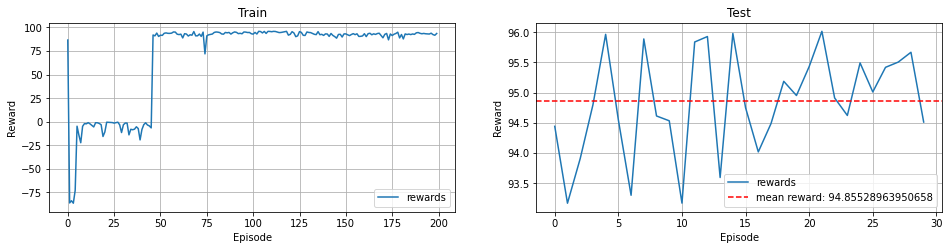

In [ ]:
Test('model.pickle', rewards, 30).picture()

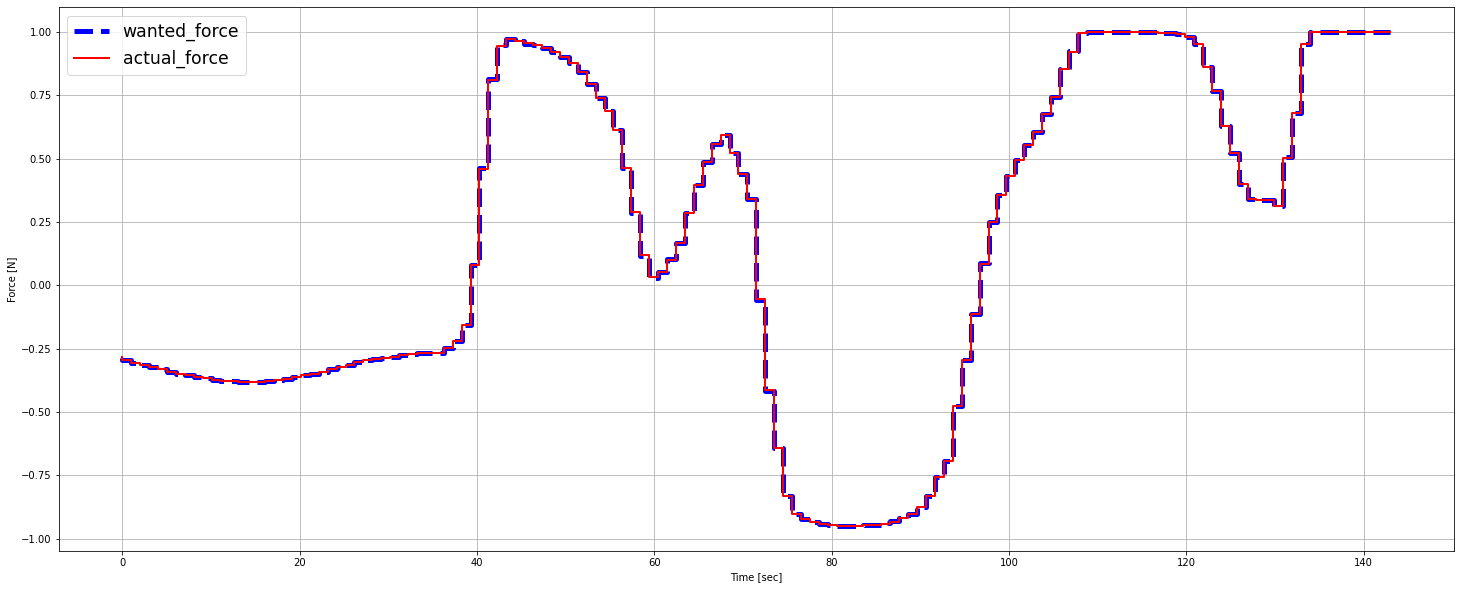

In [ ]:

dt=env.tau

#time_position_u1= np.linspace(start = 0, stop = len(save_u1)* 0.001,num=len(save_u1) ) # 1/1000=0.001
#time_position__pid_u1= np.linspace(start = 0, stop = len(save_u1)* 0.001,num=len(save_u1) )

time_position_u1= np.linspace(start = 0, stop = len(save_u1)*dt,num=len(save_u1) ) # 1/1000=0.001
time_position__pid_u1= np.linspace(start = 0, stop = len(save_u1)*dt,num=len(save_u1) )

f = plt.figure()
f.set_figwidth(25)
f.set_figheight(10)

plt.step(time_position_u1, save_u1 ,label = "wanted_force", color = 'blue',linewidth = 5, linestyle='dashed')
plt.step(time_position__pid_u1, np.array(save_pid_u1) ,label = "actual_force", color = 'red',linewidth = 2, linestyle='solid')
plt.xlabel("Time [sec]")
plt.ylabel("Force [N]")
plt.grid()
plt.legend(fontsize = 'xx-large')
plt.show()

In [ ]:
import math

position = []   #position of the car along the x-axis
velocity = []   #velocity of the car

for observ in save_observation:
  for index,value in enumerate(observ):
    if index == 0:
      position.append(value)

    if index == 1:
      velocity.append(value)

In [ ]:
print(len(position))

143


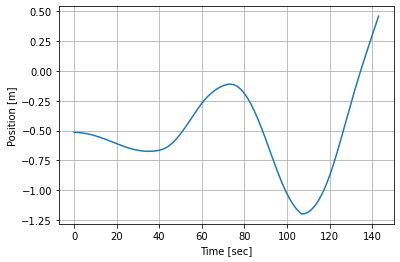

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

time_x_position = np.linspace(start = 0, stop = len(position)* dt ,num=len(position))##############################################
#time_position , position
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_x_position[-1] , 300)

spl = make_interp_spline(time_x_position, position, k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.xlabel("Time [sec]")
plt.ylabel("Position [m]")
plt.grid()
plt.show()

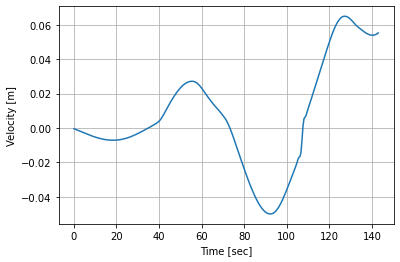

In [ ]:
time_velocity = np.linspace(start = 0, stop = len(velocity)* dt ,num=len(velocity))##############################################
#time_position , position
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_velocity[-1] , 300)

spl = make_interp_spline(time_velocity, velocity, k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.xlabel("Time [sec]")
plt.ylabel("Velocity [m]")
plt.grid()
plt.show()